#### 1. Refer to this section for a description of the problem

__[Kaggle](https://www.kaggle.com/competitions/titanic/data)__ platform provides two datasets (_train.csv_, _test.csv_) containing detailed information about Titanic passengers, such as :
- A unique identifier for each passenger (_PassengerId_) ;
- The class of service in which the passenger traveled (_Pclass_) ;
- The passenger's full name (_Name_) ;
- The gender of the passenger (_Sex_) ;
- The age of the passenger (_Age_) ;
- The number of siblings or spouses accompanying the passenger on the ship (_SibSp_) ;
- The number of parents or children accompanying the passenger on the ship (_Parch_) ;
- The ticket number assigned to the passenger (_Ticket_) ;
- The fare paid by the passenger (_Fare_) ;
- The cabin number assigned to the passenger (_Cabin_) ;
- The port from which the passenger embarked (_Embarked_) ;
- The survival status of the passenger post-collision (_Survived_), which is available only in the _train.csv_ dataset.

Based on the data and relationships identified in the _train.csv_ file, we aim to predict the survival status of passengers listed in the _test.csv_ file following the shipwreck.

#### 2. Import required libraries

In [114]:
import gc, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import kruskal
from pathlib import Path

#### 3. Set up correct path

In [115]:
windowspath__scripts = Path().resolve()
windowspath__data = windowspath__scripts.parent / "data"

#### 4. Import train.csv and test.csv files

In [116]:
df__train = pd.read_csv(filepath_or_buffer=windowspath__data / "train" / "train.csv", dtype=str)
df__test = pd.read_csv(filepath_or_buffer=windowspath__data / "test" / "test.csv", dtype=str)

In [117]:
df__train.sample(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70,1,1,WE/P 5735,71,B22,S
196,197,0,3,"Mernagh, Mr. Robert",male,NaN,0,0,368703,7.75,NaN,Q
357,358,0,2,"Funk, Miss. Annie Clemmer",female,38,0,0,237671,13,NaN,S


In [118]:
df__test.sample(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
203,1095,2,"Quick, Miss. Winifred Vera",female,8,1,1,26360,26,NaN,S
322,1214,2,"Nesson, Mr. Israel",male,26,0,0,244368,13,F2,S
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,NaN,S


#### 5. Perform feature engineering

In [119]:
# Define an unified view of df__train and df__test
df__titanic = pd.concat([df__train.copy(deep=True).drop(columns=["Survived"]), df__test.copy(deep=True)], ignore_index=True)

# Tip: samples of df__train and df__test are identified by their PassengerId

df__titanic.sample(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
502,503,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q
274,275,3,"Healy, Miss. Hanora ""Nora""",female,NaN,0,0,370375,7.75,NaN,Q
412,413,1,"Minahan, Miss. Daisy E",female,33,1,0,19928,90,C78,Q


##### *5.1. PClass, Ticket, Cabin*

In [120]:
# Remove "Ticket" and "Cabin" since their information can be seen as summarized in "PClass"
df__titanic.drop(columns=["Ticket", "Cabin"], inplace=True)

In [121]:
# Are there missing values in "Pclass" ?
df__titanic[["Pclass"]].isnull().sum()

Pclass    0
dtype: int64

In [122]:
# Create "BoardingClass" as an ordered version of "PClass" modalities

# The ordered version is such that first class is the most privileged, second class is moderately privileged, and third class is the least privileged. 
dict__pclass = {"1": "most privileged", "2": "moderately privileged", "3": "least privileged"}  

df__titanic["BoardingClass"] = df__titanic["Pclass"].map(dict__pclass)
df__titanic["BoardingClass"] = pd.Categorical(df__titanic["BoardingClass"], categories=["least privileged", "moderately privileged", "most privileged"], ordered=True)

# Cleanup
del df__titanic["Pclass"], dict__pclass

<Axes: title={'center': 'BoardingClass count distribution'}, xlabel='BoardingClass'>

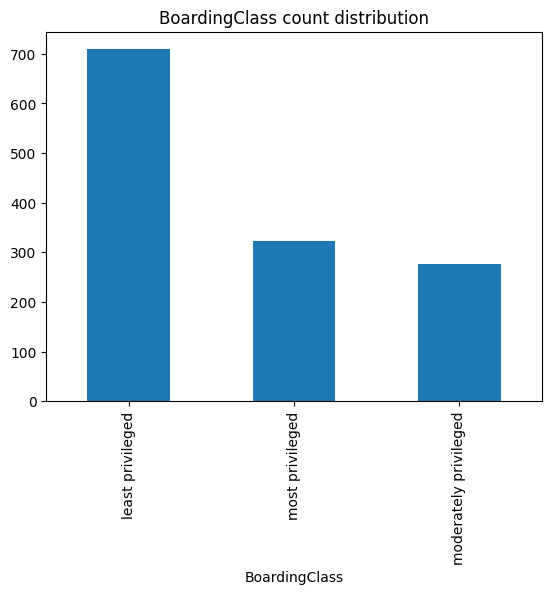

In [123]:
# Take a look at "BoardingClass"
df__titanic["BoardingClass"].value_counts().plot(kind="bar", title="BoardingClass count distribution")

<div style="background-color: green; padding: 10px;">
Half of the passengers on the ship are least privileged people.
</div>

In [124]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Name,Sex,Age,SibSp,Parch,Fare,Embarked,BoardingClass
44,45,"Devaney, Miss. Margaret Delia",female,19,0,0,7.8792,Q,least privileged
307,308,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17,1,0,108.9,C,most privileged
169,170,"Ling, Mr. Lee",male,28,0,0,56.4958,S,least privileged


##### *5.2. Name, Sex, Age*

In [125]:
# Are there missing values in "Sex" ?
df__titanic[["Sex"]].isnull().sum()

Sex    0
dtype: int64

In [126]:
# Make sure to order "Sex" values
# In Titanic emergency, women were priviliged over men
df__titanic["Sex"] = pd.Categorical(df__titanic["Sex"], categories=["male", "female"], ordered=True)

In [127]:
# Lowercase "Name" values, and remove periods
df__titanic["Name"] = df__titanic["Name"].apply(lambda x: x.lower().replace(".", ""))

<div style="background-color: green; padding: 10px;">

Research on early 20th-century naming conventions provides insights into titles incorporated in names, which often indicated age or marital status :

- Adult titles : "mr", "mrs", "sir", "rev", "capt", "dr", "col", "major", "ms", "mme", "countess", "don", "jonkheer"

- Youth titles : "master", "miss"

- Ambiguous titles : "mlle" (used for both young girls and unmarried women)

Aldulthood for men was 21; whereas for women, it was 18 or 21.

</div>

In [128]:
# Extract a "Title" column from "Name" column

# Define a list of all possible titles
list__adulttitles = ["mr", "mrs", "sir", "rev", "capt", "dr", "col", "major", "ms", "mme", "countess", "don", "jonkheer"]
list__youngtitles = ["master", "miss"]
list__ambiguoustitles = ["mlle"]
list__alltitles = list__adulttitles + list__youngtitles + list__ambiguoustitles

# An example of function to extract title
def function__title(str__name: str) -> str:
    """
    Input:
    str__name : a string (real name and title)
    Output:
    str__title : a string (title)
    """
    for str__title in list__alltitles:
        if str__title in str__name:
            return str__title

# Apply function__title on "Name" column
df__titanic["Title"] = df__titanic["Name"].apply(lambda x: function__title(x))

# Cleanup
del df__titanic["Name"], list__alltitles

<Axes: title={'center': 'Title count distribution'}, xlabel='Title'>

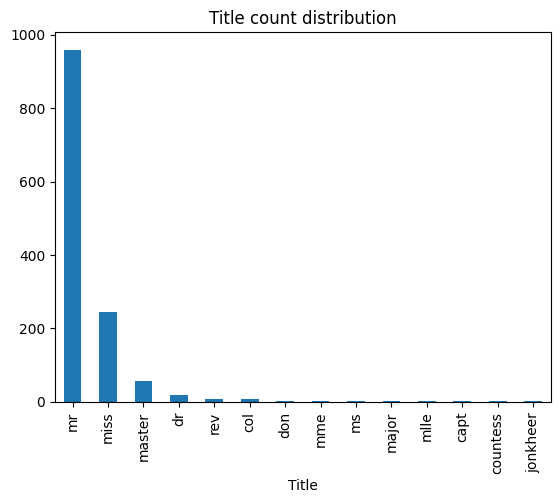

In [129]:
# Take a look at "Title"
df__titanic["Title"].value_counts().plot(kind="bar", title="Title count distribution")

<div style="background-color: green; padding: 10px;">
More than half of the passengers on the ship are adult men.
</div>

In [130]:
# Are there missing values in "Age" ?
df__titanic[["Age"]].isnull().sum()

Age    263
dtype: int64

In [131]:
# Set "Age" column data type to decimal number
df__titanic["Age"] = df__titanic["Age"].astype(float)

<div style="background-color: green; padding: 10px;">
Decimals age values can be challenging to interpret. Some of the folks who worked on Titanic problem, explained that these decimals arise when ages are estimated.
</div>

In [132]:
# Analyze the proportion of samples with missing age values
print(f"Of the {len(df__titanic)} samples, {(100*df__titanic["Age"].isnull().sum() / len(df__titanic)):.2f}% have missing age values.")

Of the 1309 samples, 20.09% have missing age values.


In [133]:
# Define a new column "AgeCategory" based on "Title" and "Age"

# An example of function to categorize age
def function__agecategory(str__title: str, float__age: float, float__adulthood = 21.0) -> str:
    """
    Input:
    str__title : a string (title)
    float__age : a decimal number (age)
    float__adulthood : a decimal number (age value to know if adulthood is reached or not)
    Output:
    str__title : a string (title)
    """
    # Test if age value is different of NA
    if float__age != np.nan:
        # Compare its value to adulthood threshold
        if float__age < float__adulthood:
            return "young"
        else: return "adult"
    
    # Test if age value is NA
    if float__age == np.nan:
        # Use title to know if adulthood is reached
        if str__title in list__adulttitles:
            return "adult"
        if str__title in list__youngtitles:
            return "young"
        if str__title in list__ambiguoustitles:
            return "young/adult"

# Apply function__agecategory
df__titanic["AgeCategory"] = df__titanic.apply(lambda row: function__agecategory(str__title=row["Title"], float__age=row["Age"]), axis=1)

# Make sure modalities of "AgeCategory" are ordered
# In Titanic emergency, young were priviliged over adult
df__titanic["AgeCategory"] = pd.Categorical(df__titanic["AgeCategory"], categories=["adult", "young/adult", "young"], ordered=True)

# Cleanup
del df__titanic["Age"], df__titanic["Title"], list__adulttitles, list__youngtitles, list__ambiguoustitles

<Axes: title={'center': 'AgeCategory count distribution'}, xlabel='AgeCategory'>

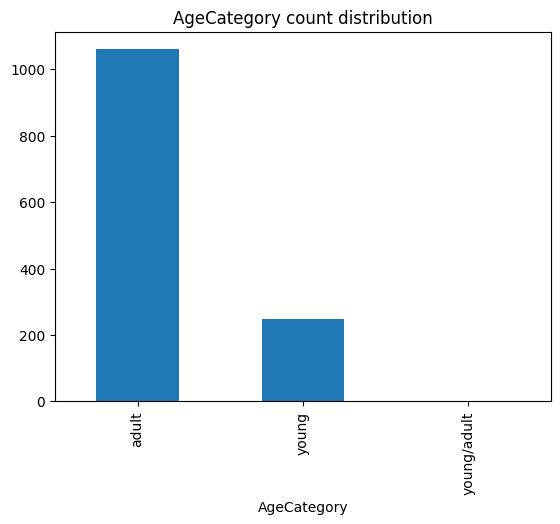

In [134]:
# Take a look at "AgeCategory"
df__titanic["AgeCategory"].value_counts().plot(kind="bar", title="AgeCategory count distribution")

<div style="background-color: green; padding: 10px;">
Since "AgeCategory" is a result of combining "Title" and "Age" in order to impute "Age" missing values, it's normal that more than half of the passengers are adults (especially adult men).
</div>

In [135]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,SibSp,Parch,Fare,Embarked,BoardingClass,AgeCategory
909,910,female,1,0,7.925,S,least privileged,adult
598,599,male,0,0,7.225,C,least privileged,adult
332,333,male,0,1,153.4625,S,most privileged,adult


##### *5.3. SibSp, ParCh, Fare*

In [136]:
# Are there missing values in "SibSp"?
df__titanic[["SibSp"]].isnull().sum()

SibSp    0
dtype: int64

In [137]:
# Are there missing values in "Parch"?
df__titanic[["Parch"]].isnull().sum()

Parch    0
dtype: int64

In [138]:
# Set "SibSp" and "Parch" data type to integer
df__titanic[["SibSp","Parch"]] = df__titanic[["SibSp","Parch"]].astype(int)

# Create "FamilySize" by incrementing of 1 the sum of "SibSp" and "Parch" 
df__titanic["FamilySize"] = df__titanic[["SibSp","Parch"]].sum(axis=1) + 1

# Cleanup
df__titanic.drop(columns=["SibSp","Parch"], inplace=True)

<Axes: title={'center': 'FamilySize count distribution'}, xlabel='FamilySize'>

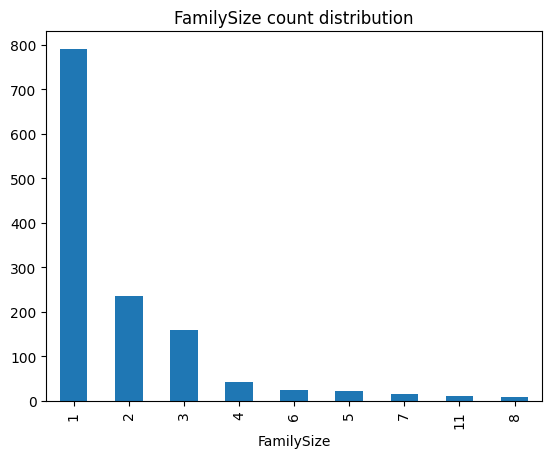

In [139]:
# Take a look at "FamilySize"
df__titanic["FamilySize"].value_counts().plot(kind="bar", title="FamilySize count distribution")

<div style="background-color: green; padding: 10px;">
More than half of the passengers on the ship were alone.
</div>

In [140]:
# Are there missing values in "Fare" ?
df__titanic[["Fare"]].isnull().sum()

# Only one passenger "Fare" seems to be missing.

Fare    1
dtype: int64

<Axes: title={'center': 'Fare distribution'}, ylabel='Frequency'>

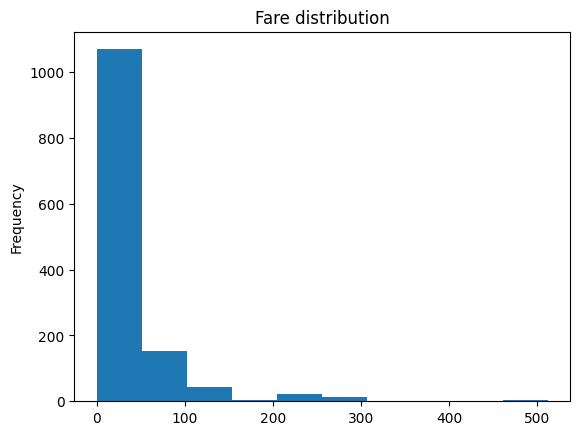

In [141]:
# Set "Fare" data type to float
df__titanic["Fare"] = df__titanic["Fare"].astype(float)

# Take a look at "Fare"
df__titanic["Fare"].plot(kind="hist", title="Fare distribution")

<div style="background-color: green; padding: 10px;">
"Fare" distribution is right-skewed, which is normal since most of the people were least priviliged (3rd class tickets).
Let's dive further.
</div>

In [142]:
# Cross "Fare" values with "BoardingClass"
df__titanic[["Fare", "BoardingClass"]].groupby(["BoardingClass"], observed=False).describe()

Fare                                               \
                       count       mean        std  min      25%      50%   
BoardingClass                                                               
least privileged       708.0  13.302889  11.494358  0.0   7.7500   8.0500   
moderately privileged  277.0  21.179196  13.607122  0.0  13.0000  15.0458   
most privileged        323.0  87.508992  80.447178  0.0  30.6958  60.0000   

                                           
                            75%       max  
BoardingClass                              
least privileged        15.2458   69.5500  
moderately privileged   26.0000   73.5000  
most privileged        107.6625  512.3292

<div style="background-color: green; padding: 10px;">
Tickets' Fare seems to depend on "BoardingClass" as we thought after "Fare" distribution analysis. Let's approximate the dependency/correlation strength between these two features.
</div>

In [143]:
# Do a Kruskall-Wallis test between "Fare" and "BoardingClass" as a proof of high correlation between these two features

# Do not consider the passenger with missing "Fare"
df__table = df__titanic[["Fare", "BoardingClass"]].copy(deep=True).dropna()

# Perform a Kruskall-Wallis test with a 95% level of confidence
kruskal(*df__table.groupby(["BoardingClass"], observed=False)["Fare"].apply(list))

KruskalResult(statistic=np.float64(675.6437116957771), pvalue=np.float64(1.9312217278120738e-147))

<div style="background-color: green; padding: 10px;">

Based on 1308 passengers with no missing "Fare" value :
- The p-value computed from a Kruskal-Wallis test with 95% level of confidence between "Fare" and "BoardingClass" is up to 3.24e-72 ;
- The p-value computed is much lesser than 0.05, and we conclude that there's statistically a high dependency/correlation between these two features.

Since "Fare" is the one with one missing value out of 1309 passengers, we'll remove it and keep only "BoardingClass".
</div>

In [144]:
# Cleanup
del df__table, df__titanic["Fare"]

In [146]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
937,938,male,C,most privileged,adult,1
821,822,male,S,least privileged,adult,1
755,756,male,S,moderately privileged,young,3


##### *5.4. Embarked*

In [148]:
# Are there missing values in "Embarked" ?
df__titanic[["Embarked"]].isnull().sum()

# Two passengers' embarkation towns are missing.

Embarked    2
dtype: int64

<Axes: title={'center': 'Embarked count distribution'}, xlabel='Embarked'>

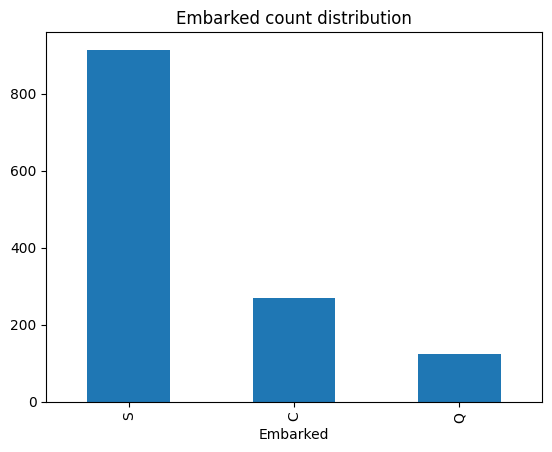

In [149]:
# Take a look at "Embarked"
df__titanic["Embarked"].value_counts().plot(kind="bar", title="Embarked count distribution")

In [151]:
# We choose to impute the most present modality to these two passengers with missing embarkation towns
df__titanic["Embarked"].fillna(value=df__titanic["Embarked"].mode()[0], inplace=True)

<div style="background-color: green; padding: 10px;">

We conducted research on the lifestyles of the towns the Titanic visited: Southampton (S), Cherbourg (C), and Queenstown (Q) :
- In 1900, Ireland was still recovering from the Great Famine, so residents of Queenstown likely faced more hardships due to economic struggles.
- Southampton, being a major port city, probably offered better economic opportunities compared to Queenstown.
- Cherbourg, also a port city, might have been somewhere in between these two towns in terms of lifestyle.

We decided to rank these cities as "S" < "C" < "Q", concluding that people from Queenstown were more resilient in life-threatening situations than those from Cherbourg, who in turn would react better than those from Southampton.
</div>

In [152]:
# Order "Embarked" modalities
df__titanic["Embarked"] = pd.Categorical(df__titanic["Embarked"], categories=["S", "C", "Q"], ordered=True)

In [153]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
675,676,male,S,least privileged,young,1
317,318,male,S,moderately privileged,adult,1
87,88,male,S,least privileged,adult,1


##### *5.1. Retrieve engineered versions of df__train and df__test*

In [ ]:
# Get engineered version of df__train

In [145]:
# %reset -f